LangGraph built visa agent that has memory and human feedback in the loop.

Ex. What is the visa fees? The agent asks which visa to specify.
https://github.com/krishnaik06/Agentic-LanggraphCrash-course/blob/main/1-BasicChatbot/chatbot.ipynb

In [35]:
from langchain_community.tools import DuckDuckGoSearchRun

In [36]:
pip install -U ddgs


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [37]:
search = DuckDuckGoSearchRun()

In [38]:
tools=[search]

In [39]:
from langchain.chat_models.base import init_chat_model
llm = init_chat_model("ollama:llama3.2:3b")


In [40]:
llm_with_tool = llm.bind_tools(tools)

In [41]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages

In [42]:
from langgraph.types import Command, interrupt

In [43]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages:Annotated[list,add_messages]

In [44]:
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]


In [45]:
from langgraph.prebuilt import ToolNode

In [46]:
tool_node = ToolNode(tools=tools)

In [47]:
def chatbot(state: State):
    message = llm_with_tool.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    
    return {"messages": [message]}

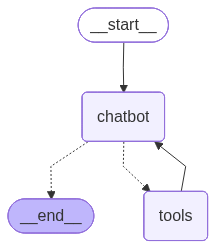

In [48]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder= StateGraph(State)
builder.add_node("chatbot", chatbot)
tool_node = ToolNode(tools)
builder.add_node("tools", tool_node)
builder.add_edge("tools", "chatbot")
## Add Edges
builder.add_edge(START, "chatbot")
builder.add_conditional_edges(
    "chatbot",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge(START, "chatbot")

## compile the graph
graph=builder.compile(checkpointer=memory)

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

config={"configurable":{"thread_id":"1"}}

response=graph.invoke({"messages":"what is my name?"},config=config)

response

In [55]:
user_input = "The green card visa fees is $350."
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": user_input},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

The green card visa fees is $350.
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (ed741126-1e95-429b-851e-f44a6cb0ac1c)
 Call ID: ed741126-1e95-429b-851e-f44a6cb0ac1c
  Args:
    query: green card visa fees
================================= Tool Message =================================
Name: duckduckgo_search

Jul 18, 2025 · The new fees in this FRN are: A new fee of $100 for aliens who file Form I-589, Application for Asylum and for Withholding of Removal. Jun 25, 2025 · Green card costs in 2025 can be substantial, typically ranging from $2,000 to $3,000 for family-based applications and $2,000 to $5,000 or more for ... Mar 19, 2025 · Renewing your Green Card in 2025 involves a Form I-90 filing fee of $465 ($415 if filed online) and a biometrics fee of $85, with optional legal fees if using ... Nov 12, 2025 · A filing fee is required for 

In [56]:
user_input = "What is green card visa fees I told you earlier."
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": user_input},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

What is green card visa fees I told you earlier.
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (037e47ce-aab0-4da9-a444-4da059cc03cc)
 Call ID: 037e47ce-aab0-4da9-a444-4da059cc03cc
  Args:
    query: green card visa fees
================================= Tool Message =================================
Name: duckduckgo_search

Jul 18, 2025 · The new fees in this FRN are: A new fee of $100 for aliens who file Form I-589, Application for Asylum and for Withholding of Removal. Jun 25, 2025 · Green card costs in 2025 can be substantial, typically ranging from $2,000 to $3,000 for family-based applications and $2,000 to $5,000 or more for ... Mar 19, 2025 · Renewing your Green Card in 2025 involves a Form I-90 filing fee of $465 ($415 if filed online) and a biometrics fee of $85, with optional legal fees if using ... Nov 12, 2025 · A filing fee i